<a href="https://colab.research.google.com/github/duongtrung/Pytorch-tutorials/blob/main/15_pytorch_multivariate_timeseries_forecasting_LSTM_v1_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

In [1]:
# dataset: https://finance.yahoo.com/quote/GE/history/
# select Max in the Time Period if you want to get all datasets until your current date

In [73]:
# General design
# One-step-ahead
# Multivariate
# The first data's column is the target

In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

In [41]:
df = pd.read_csv("data/GE-3months.csv")

In [42]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-27,107.879997,108.279999,103.690002,103.849998,103.414063,8984300
1,2021-10-28,103.389999,105.379997,103.099998,105.260002,104.818161,5910800
2,2021-10-29,104.949997,105.239998,104.120003,104.870003,104.429794,5618700
3,2021-11-01,105.760002,106.769997,105.279999,106.230003,105.784088,4887100
4,2021-11-02,106.339996,107.139999,105.300003,106.690002,106.242149,4480800


In [43]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,83.730675,84.845635,82.511746,83.657143,83.445877,6.696986e+06
std,13.882652,13.905495,13.732063,13.747321,13.627205,2.945638e+06
min,61.000000,61.160000,59.930000,61.090000,61.014286,3.269000e+06
25%,72.885000,73.830000,71.139999,72.725000,72.679544,4.980125e+06
50%,80.029999,81.525002,79.110000,80.509998,80.314315,6.147600e+06
75%,94.945001,96.064999,93.650002,94.922501,94.610777,7.606150e+06
max,114.730003,116.169998,110.480003,111.290001,110.822838,2.875490e+07


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Open       252 non-null    float64
 2   High       252 non-null    float64
 3   Low        252 non-null    float64
 4   Close      252 non-null    float64
 5   Adj Close  252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [45]:
# separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [46]:
train_dates.head(5)

0   2021-10-27
1   2021-10-28
2   2021-10-29
3   2021-11-01
4   2021-11-02
Name: Date, dtype: datetime64[ns]

In [47]:
# variables for training
cols = list(df)[1:3] # ['Open', 'High', 'Low', 'Close', 'Adj Close']

In [160]:
number_of_features = len(cols)

In [48]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

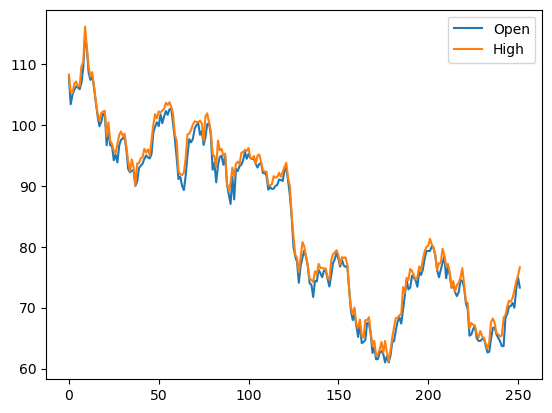

In [49]:
df_for_training.plot.line()

In [50]:
scaler =  StandardScaler() #RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [51]:
df_for_training_scaled.shape

(252, 2)

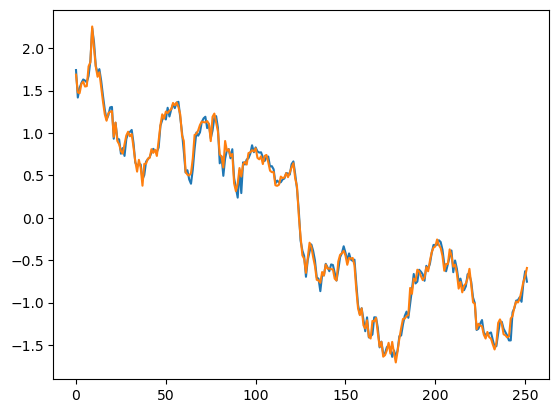

In [52]:
plt.plot(df_for_training_scaled)
plt.show()

In [53]:
np.savetxt("data/GE_3months_scaled_multivariate.csv", df_for_training_scaled, delimiter=',')

In [177]:
##splitting dataset into train and test split for time series data
training_size = int(len(df_for_training_scaled)*0.65)
test_size = len(df_for_training_scaled)-training_size
train_data,test_data = df_for_training_scaled[0:training_size,:], df_for_training_scaled[training_size:len(df_for_training_scaled),:]

In [55]:
train_data.shape, test_data.shape

((201, 2), (51, 2))

In [56]:
train_data[0], test_data[0]

(array([1.74299417, 1.68861294]), array([-0.31834351, -0.25548805]))

In [57]:
train_data[1], test_data[1]

(array([1.41892543, 1.47964713]), array([-0.26493364, -0.32178104]))

In [58]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
past_observation = 10

In [181]:
class MultiSequenceDataset(Dataset):
    def __init__(self,data,past_len = past_observation):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.past_len = past_len
        
    def __len__(self):
        return len(self.data)-self.past_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.past_len, :].reshape(-1,1) , self.data[index+self.past_len, :][0]


train_dataset = MultiSequenceDataset(train_data, past_len=past_observation) 
test_dataset = MultiSequenceDataset(test_data, past_len=past_observation) 

In [182]:
len(train_dataset)

152

In [183]:
train_dataset[0]

(tensor([[1.7430],
         [1.6886],
         [1.4189],
         [1.4796],
         [1.5315],
         [1.4696],
         [1.5900],
         [1.5798],
         [1.6318],
         [1.6065],
         [1.6189],
         [1.5488],
         [1.5979],
         [1.5531],
         [1.6744],
         [1.7873],
         [1.8527],
         [1.8349],
         [2.2374],
         [2.2571]]),
 tensor(2.0764))

In [184]:
train_dataset[1]

(tensor([[1.4189],
         [1.4796],
         [1.5315],
         [1.4696],
         [1.5900],
         [1.5798],
         [1.6318],
         [1.6065],
         [1.6189],
         [1.5488],
         [1.5979],
         [1.5531],
         [1.6744],
         [1.7873],
         [1.8527],
         [1.8349],
         [2.2374],
         [2.2571],
         [2.0764],
         [2.0057]]),
 tensor(1.7914))

In [185]:
train_dataset[2]

(tensor([[1.5315],
         [1.4696],
         [1.5900],
         [1.5798],
         [1.6318],
         [1.6065],
         [1.6189],
         [1.5488],
         [1.5979],
         [1.5531],
         [1.6744],
         [1.7873],
         [1.8527],
         [1.8349],
         [2.2374],
         [2.2571],
         [2.0764],
         [2.0057],
         [1.7914],
         [1.7837]]),
 tensor(1.7084))

In [186]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size , drop_last=True)

In [188]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size = hidden_size, num_layers= num_layers, dropout=0, bidirectional=False)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn)) # out shape (past observation, batch_size, hidden_size)
        
        final_out = self.fc(out[-1])   # out[-1].shape: torch.Size([batch_size, hidden_size])
        return final_out,hn,cn # final_out.shape: [batch_size,1]

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])  
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size, self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size, self.hidden_size).to(device)
        return h0 , c0

In [189]:
input_dim = 1
hidden_size = 30
num_layers = 5

In [190]:
model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [191]:
from torchsummary import summary
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              33,720
├─Linear: 1-2                            31
Total params: 33,751
Trainable params: 33,751
Non-trainable params: 0

In [192]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [199]:
def train(dataloader):
    hn , cn = model.init()
    model.train()
    losses = []
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(past_observation*number_of_features, batch_size, 1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        losses.append(loss.item())
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_train = np.sum(losses) / len(dataloader)
    #print(f"train loss: {loss_train:>8f} ")
    return loss_train 

In [202]:
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    losses = []
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(past_observation*number_of_features,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        losses.append(loss.item())
       
    loss_test = np.sum(losses) / len(dataloader)
    #print(f"test loss: {loss_test:>8f} ")
    return loss_test

In [203]:
epochs = 50
train_losses = []
test_losses = []
for epoch in range(epochs):
    train_losses.append(train(train_dataloader))
    test_losses.append(test(test_dataloader))
    if epoch % 5 == 0:
        print(f"epoch {epoch} ")
        print(train_losses[epoch], test_losses[epoch])

epoch 0 
0.7024795514972586 1.2941486380602185
epoch 5 
0.5202001813848159 1.7940321894068467
epoch 10 
0.2804222287806241 1.3965904461710077
epoch 15 
0.20894393931437089 1.1552318432613422
epoch 20 
0.16950585617144642 0.9212096223705694
epoch 25 
0.1267156468361224 0.6159118895394433
epoch 30 
0.09544247604514423 0.3218157866871671
epoch 35 
0.09072686391147344 0.26128815339976236
epoch 40 
0.08788215529516731 0.25572314086419184
epoch 45 
0.08468498353307184 0.2550474925113744


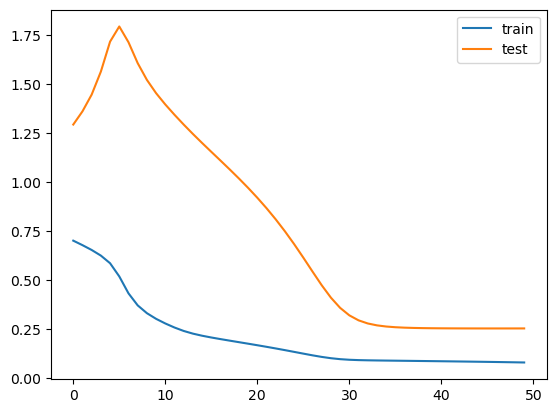

In [204]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()

In [259]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        
        for batch , item in enumerate(data_loader):
            x , y = item
            y = y.reshape(batch_size, -1)
            x , y = x.to(device) , y.to(device)
            print(y)
            x = x.view(past_observation*number_of_features,batch_size,1)
            pred = model(x,hn,cn)[0]
            print(pred)
            pred = np.repeat(pred.detach().cpu(), number_of_features, axis=-1)
            print(pred)
            pred = scaler.inverse_transform(pred) #.reshape(-1)
            #pred = pred[0]
            print(pred)
            print(pred[:,0])
            y = np.repeat(y.detach().cpu(), number_of_features, axis=-1)
            print("yyyyyyyyyy")
            print(y)
            y = scaler.inverse_transform(y) #.reshape(-1)
            print(y)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        #print(pred_arr[21],y_arr[21])
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [260]:
# calculating final loss metrics
print("final loss metrics after inversing scaling")
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

final loss metrics after inversing scaling
tensor([[2.0764],
        [1.7914],
        [1.7084],
        [1.7538]], device='cuda:0')
tensor([[1.1424],
        [1.1405],
        [1.1487],
        [1.1471]], device='cuda:0')
tensor([[1.1424, 1.1424],
        [1.1405, 1.1405],
        [1.1487, 1.1487],
        [1.1471, 1.1471]])
[[ 99.55876379 100.69976924]
 [ 99.53173282 100.67269379]
 [ 99.64666648 100.78781657]
 [ 99.62348221 100.76459415]]
[99.55876379 99.53173282 99.64666648 99.62348221]
yyyyyyyyyy
tensor([[2.0764, 2.0764],
        [1.7914, 1.7914],
        [1.7084, 1.7084],
        [1.7538, 1.7538]])
[[112.49999939 113.66229957]
 [108.55000239 109.70580287]
 [107.40000184 108.55391001]
 [108.0299989  109.18494372]]
tensor([[1.6181],
        [1.4413],
        [1.2775],
        [1.1598]], device='cuda:0')
tensor([[1.1545],
        [1.1523],
        [1.1536],
        [1.1510]], device='cuda:0')
tensor([[1.1545, 1.1545],
        [1.1523, 1.1523],
        [1.1536, 1.1536],
        [1.151